In [ ]:
import torch, sys, yaml, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import random, shutil   
from typing import List, Set

print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

from pathlib import Path
DATA_ROOT = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1") 
DATA_YAML = DATA_ROOT / "data.yaml"

for p in ["train/images","train/labels","valid/images","valid/labels","test/images","test/labels"]:
    d = DATA_ROOT / p
    print(f"{p:>20} -> {d.exists()} ({len(list(d.glob('*')))} files)")

SUPPORTED_IMG_EXTS = {
    "webp","jpeg","tiff","dng","jpg","bmp","heic","png","tif","mpo","pfm"
}

%matplotlib inline

# ------- Paths -------
V2_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml")
V3_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml")

BEST_V1 = r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v1\weights\best.pt"
BEST_V2 = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2_final_sgd\weights\best.pt")



Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Torch: 2.3.1+cu121 | CUDA available? True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
        train/images -> True (240 files)
        train/labels -> True (240 files)
        valid/images -> True (60 files)
        valid/labels -> True (60 files)
         test/images -> False (0 files)
         test/labels -> False (0 files)


# Version 1

### This is the first model using the 300 images that we labelled on Roboflow. We did a 80/20 split so 240 images from the kaggle dataset for training and 60 images from our own dataset for validation. 
### We use the YOLOv8s with 150 epochs, patience 30 and augmentations like slight tilting and flipped image.

In [ ]:
model = YOLO("yolov8s.pt")
results = model.train(
    data=str(DATA_YAML),
    imgsz=896, rect=True,       
    epochs=150, batch=8,
    cache="ram",device=0, workers=2,
    # augmentations
    fliplr=0.5, flipud=0.0,
    degrees=7.0, translate=0.04, scale=0.5, 
    shear=3.0, perspective=0.0,
    mosaic=0.15, mixup=0.0, copy_paste=0.0,
    close_mosaic=10,
    optimizer="AdamW",
    cos_lr=True, lr0=0.004, patience=30,
    project="runs", name="exercise_v1"
)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1\data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

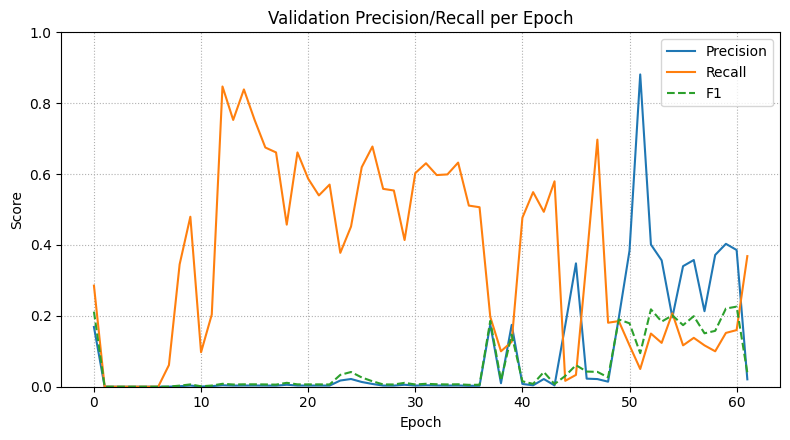

In [ ]:
run_dir = Path(results.save_dir)
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

In [4]:
metrics = model.val(data=str(DATA_YAML))
print(f"mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 423.1159.0 MB/s, size: 71.6 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1\valid\labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 60.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.9it/s 4.2s0.7ss
                   all         60         62    0.00415      0.631     0.0905     0.0377
            benchpress         10         12     0.0062      0.667    0.00588    0.00155
              deadlift         10         10    0.00217        0.5     0.0253     0.0044
               leg_ext         10         10    0.00819        0.7     0.0165    0.00358
              

### This is the start of our 'Active Learning' where we use the model to predict the next 300 images to get the labels and bounding boxes.

In [ ]:
ROOT = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset")
WEIGHTS = ROOT.parent / "runs" /  "exercise_v1" / "weights" / "best.pt"
if not WEIGHTS.exists():
    WEIGHTS = Path("yolov8s.pt")

N_TRAIN_PER_CLASS = 40
N_VAL_PER_CLASS   = 10
SEED = 42
CONF, IOU, IMGSZ = 0.5, 0.40, 896

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp",
            ".JPG",".JPEG",".PNG",".BMP",".TIF",".TIFF",".WEBP"}

# --- paths ---
TRAIN_EXIST = ROOT / "images" / "train"
VAL_EXIST   = ROOT / "images" / "val"
POOL_A      = ROOT / "pool_dataset"
POOL_B      = ROOT / "pool_dataset_cz"
OUT         = ROOT / "v2"
OUT_IMG_T   = OUT / "images" / "train"
OUT_IMG_V   = OUT / "images" / "val"
OUT_LAB_T   = OUT / "labels" / "train"
OUT_LAB_V   = OUT / "labels" / "val"
for d in [OUT_IMG_T, OUT_IMG_V, OUT_LAB_T, OUT_LAB_V]:
    d.mkdir(parents=True, exist_ok=True)

# --- helpers ---
def list_imgs(d: Path):
    return [p for p in d.iterdir() if p.is_file() and p.suffix in IMG_EXTS]

def stems_in(d: Path):
    return {p.stem for p in d.rglob("*") if p.suffix in IMG_EXTS}

# avoid overlap with existing splits
train_stems_existing = stems_in(TRAIN_EXIST) if TRAIN_EXIST.exists() else set()
val_stems_existing   = stems_in(VAL_EXIST)   if VAL_EXIST.exists() else set()

rng = random.Random(SEED)

classes = sorted([x.name for x in POOL_A.iterdir() if x.is_dir()])
assert all((POOL_B / c).exists() for c in classes), "Class folders mismatch between pools."

# --- pick & copy ---
def pick_and_copy(pool_dir: Path, out_dir: Path, per_class: int, ban_stems: set):
    picked = []
    for c in classes:
        src = pool_dir / c
        imgs = [p for p in list_imgs(src) if p.stem not in ban_stems]
        rng.shuffle(imgs)
        take = imgs[:min(per_class, len(imgs))]
        for p in take:
            shutil.copy2(p, out_dir / p.name)
        picked.extend(take)
        print(f"{pool_dir.name}/{c:<16} -> {len(take):>2}/{per_class}")
    return picked

print("Picking TRAIN from pool_dataset …")
picked_train = pick_and_copy(POOL_A, OUT_IMG_T, N_TRAIN_PER_CLASS, train_stems_existing | val_stems_existing)

print("\nPicking VAL from pool_dataset_cz …")
picked_val   = pick_and_copy(POOL_B, OUT_IMG_V, N_VAL_PER_CLASS,   train_stems_existing | val_stems_existing)

print(f"\nTotals: train={len(picked_train)}  val={len(picked_val)}")

# --- pseudo-label the bundle ---
model = YOLO(str(WEIGHTS))
def predict_into(name:str, src_dir:Path):
    pred_dir = OUT / f"_pred_{name}"
    model.predict(
        source=str(src_dir),
        imgsz=IMGSZ, conf=CONF, iou=IOU, agnostic_nms=True, max_det=6,
        augment=False, save=False, save_txt=True, save_conf=True,
        project=str(OUT), name=f"_pred_{name}", exist_ok=True
    )
    return pred_dir / "labels"

lab_t_src = predict_into("train", OUT_IMG_T)
lab_v_src = predict_into("val",   OUT_IMG_V)

# copy predicted labels next to images; create empty .txt when no prediction
def materialize_labels(img_dir: Path, pred_lab_dir: Path, out_lab_dir: Path):
    have = set()
    if pred_lab_dir.exists():
        for txt in pred_lab_dir.glob("*.txt"):
            shutil.copy2(txt, out_lab_dir / txt.name)
            have.add(txt.stem)
    for img in img_dir.glob("*"):
        if img.stem not in have:
            (out_lab_dir / f"{img.stem}.txt").touch()

materialize_labels(OUT_IMG_T, lab_t_src, OUT_LAB_T)
materialize_labels(OUT_IMG_V, lab_v_src, OUT_LAB_V)

print(OUT.resolve())

Picking TRAIN from pool_dataset …
pool_dataset/benchpress       -> 40/40
pool_dataset/deadlift         -> 40/40
pool_dataset/leg_extension    -> 40/40
pool_dataset/pushup           -> 40/40
pool_dataset/shoulder_press   -> 40/40
pool_dataset/squat            -> 40/40

Picking VAL from pool_dataset_cz …
pool_dataset_cz/benchpress       -> 10/10
pool_dataset_cz/deadlift         -> 10/10
pool_dataset_cz/leg_extension    -> 10/10
pool_dataset_cz/pushup           -> 10/10
pool_dataset_cz/shoulder_press   -> 10/10
pool_dataset_cz/squat            -> 10/10

Totals: train=240  val=60

image 1/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v2\images\train\bench press_1200101.jpg: 672x896 (no detections), 134.5ms
image 2/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v2\images\train\bench press_1700071.jpg: 672x896 (no detections), 28.9ms
ima

# Version 2

### Next for our version 2, we decided to train 2 models, baseline and a warm start from using the weights from the previous model. Both uses the same parameters as version 1. 

### Baseline

In [ ]:
RUN_NAME = "v2_baseline"

model = YOLO("yolov8s.pt")
results = model.train(
    data=str(V2_YAML),
    imgsz=896, rect=True,
    epochs=150, batch=8,
    cache="ram",device=0, workers=2,
    # augmentations
    fliplr=0.5, flipud=0.0,
    degrees=7.0, translate=0.04, scale=0.5, 
    shear=3.0, perspective=0.0,
    mosaic=0.15, mixup=0.0, copy_paste=0.0,
    close_mosaic=10,
    optimizer="AdamW",
    cos_lr=True, lr0=0.004, patience=30,
    project="runs", name="exercise_v2baseline"
)
# Evaluate on V2 val/test
best_pt = rf"runs/exercise_v2baseline/weights/best.pt"
m = YOLO(best_pt)
metrics = m.val(data=V2_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

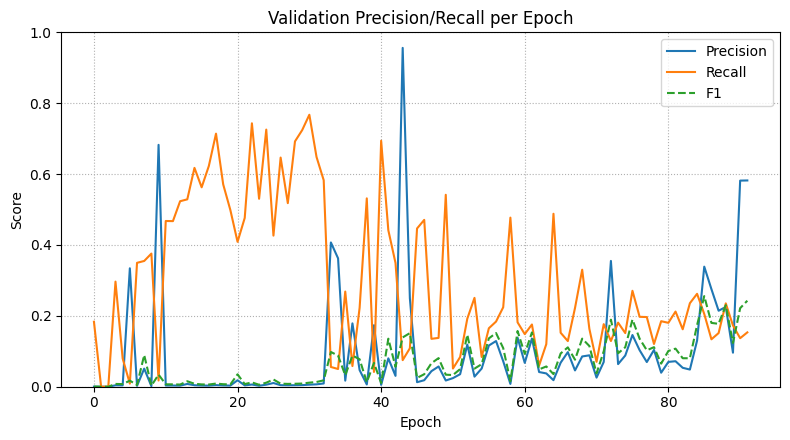

In [ ]:
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2baseline")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

### Warmstart

In [ ]:
RUN_NAME = "v2_best"

model = YOLO(BEST_V1)  
results = model.train(
    data=str(V2_YAML),
    imgsz=896,rect=True,
    epochs=150,batch=8,
    cache="ram", device=0, workers=2,
    # augmentations
    fliplr=0.5, flipud=0.0,
    degrees=7.0, translate=0.04, 
    scale=0.5, shear=3.0, perspective=0.0,
    mosaic=0.15, mixup=0.0, copy_paste=0.0,
    close_mosaic=10,
    optimizer="AdamW",
    cos_lr=True, lr0=0.004, patience=30,
    project="runs", name="exercise_v2best"
)

# Evaluate on V2 val/test
BEST_V2 = rf"runs/exercise_v2best/weights/best.pt"
m = YOLO(BEST_V2)
metrics = m.val(data=V2_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml, degrees=7.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

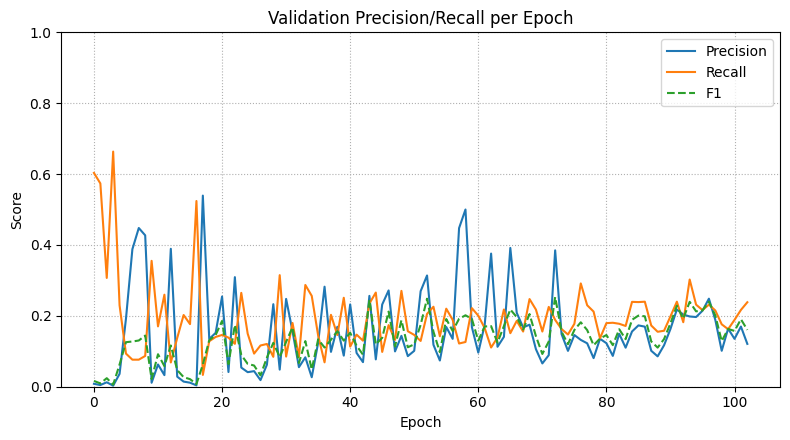

In [ ]:
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v2best")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

### Comparison of both models

In [ ]:
BASE_PT = rf"runs/exercise_v2baseline/weights/best.pt"
BEST_PT = rf"runs/exercise_v2best/weights/best.pt"

def load_class_names(yaml_path):
    with open(yaml_path, "r", encoding="utf-8") as f:
        y = yaml.safe_load(f)
    if isinstance(y.get("names"), list):
        return y["names"]
    return [y["names"][i] for i in range(len(y["names"]))]

NAMES = load_class_names(V2_YAML)

def eval_model(weights_path, yaml_path):
    y = YOLO(weights_path)
    metrics = y.val(data=yaml_path, verbose=False, plots=False)
    # overall
    out = {
        "mAP50": float(metrics.box.map50),
        "mAP50-95": float(metrics.box.map),
    }
    # per-class (Ultralytics reliably exposes per-class mAP50-95 as metrics.box.maps)
    per_ap5095 = list(metrics.box.maps)
    # try to fetch per-class AP50 if available on your version; else None
    per_ap50 = getattr(metrics.box, "maps50", None)
    if per_ap50 is not None:
        per_ap50 = list(per_ap50)
    return out, per_ap50, per_ap5095

# ---- run evals
overall_base, ap50_base, ap5095_base = eval_model(BASE_PT, V2_YAML)
overall_best, ap50_best, ap5095_best = eval_model(BEST_PT, V2_YAML)

# 1) One-glance comparison table
df_overall = pd.DataFrame([
    {"Model":"V2 baseline (COCO init)", **overall_base},
    {"Model":"V2 best (warm-start from V1)", **overall_best},
])

# 2) Per-class table (uses AP50 if available; otherwise mAP50-95). Also compute deltas.
def per_class_df(names, base50, best50, base5095, best5095):
    rows = []
    for i, cls in enumerate(names):
        row = {"Class": cls}
        # AP50 columns (if available)
        if base50 is not None and best50 is not None:
            row["AP50_V2_base"] = round(float(base50[i]), 4)
            row["AP50_V2_best"] = round(float(best50[i]), 4)
            row["Δ AP50"]        = round(row["AP50_V2_best"] - row["AP50_V2_base"], 4)
        # AP50-95 columns (always available)
        row["mAP50-95_V2_base"] = round(float(base5095[i]), 4)
        row["mAP50-95_V2_best"] = round(float(best5095[i]), 4)
        row["Δ mAP50-95"]       = round(row["mAP50-95_V2_best"] - row["mAP50-95_V2_base"], 4)
        rows.append(row)
    # nice sort: largest improvement first by mAP50-95 delta
    return pd.DataFrame(rows).sort_values(by="Δ mAP50-95", ascending=False)

df_perclass = per_class_df(NAMES, ap50_base, ap50_best, ap5095_base, ap5095_best)

def hide_index(styler):
    if hasattr(styler, "hide"):
        return styler.hide(axis="index")
    if hasattr(styler, "hide_index"):
        return styler.hide_index()
    return styler.set_table_styles([
        {"selector": "th.row_heading", "props": [("display", "none")]},
        {"selector": "tbody tr th",    "props": [("display", "none")]}
    ])

def pretty(styler):
    return (hide_index(styler)
            .set_properties(**{"text-align": "center", "padding": "6px 12px"}))

# ---- OVERALL ----
display(pretty(
    df_overall.rename(columns={"mAP50":"mAP@50","mAP50-95":"mAP@[50:95]"})
              .round(3)
              .style
))

# ---- PER-CLASS ----
use_ap50 = "Δ AP50" in df_perclass.columns
cols_gain = (["Class","AP50_V2_base","AP50_V2_best","Δ AP50"] if use_ap50 else ["Class"]) \
            + ["mAP50-95_V2_base","mAP50-95_V2_best","Δ mAP50-95"]

# A) sort by gain
t_gain = df_perclass.sort_values("Δ mAP50-95", ascending=False)[cols_gain].round(3)
display(pretty(t_gain.style))

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 510.1176.5 MB/s, size: 67.4 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\valid\labels.cache... 120 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 119.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.9it/s 2.8s0.2ss
                   all        120        123      0.136      0.176      0.162     0.0641
Speed: 1.2ms preprocess, 9.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fa

Model,mAP@50,mAP@[50:95]
V2 baseline (COCO init),0.162000,0.064000
V2 best (warm-start from V1),0.209000,0.065000


Class,mAP50-95_V2_base,mAP50-95_V2_best,Δ mAP50-95
squat,0.054000,0.182000,0.128000
pushup,0.058000,0.171000,0.113000
shoulder_press,0.001000,0.001000,-0.001000
leg_ext,0.012000,0.011000,-0.002000
benchpress,0.019000,0.005000,-0.014000
deadlift,0.240000,0.023000,-0.217000


Class,mAP50-95_V2_base,mAP50-95_V2_best,Δ mAP50-95
benchpress,0.019000,0.005000,-0.014000
deadlift,0.240000,0.023000,-0.217000
leg_ext,0.012000,0.011000,-0.002000
pushup,0.058000,0.171000,0.113000
shoulder_press,0.001000,0.001000,-0.001000
squat,0.054000,0.182000,0.128000


#### Overall, mAP@50 improves from 0.162 to 0.209, but mAP@[50:95] is basically flat (0.064 → 0.065). So V2 finds more objects at IoU 0.5, but it doesn’t place boxes more precisely across stricter IoUs. For the classes, squat and pushup improves slightly while deadlift drops massively from 0.24 to 0.02. Most likely it is under representation for all the classes.

### Ablation study

#### Next, we did an ablation study to try and tune our hyperparameters to find out whether which ones can help improve the model. 

#### We have 7 different runs
#### 1. Baseline
#### 2. Warmstart
#### 3. Adjust mosiac to 0.25
#### 4. SGD Optimiser
#### 5. Adam Optimiser
#### 6. SGD Optimiser + LR change to 0.01
#### 7. Adam Optimiser + LR change to 0.0025

In [ ]:
COMMON = {
    "data": str(V2_YAML), "imgsz": 896, "rect": True,
    "epochs": 80, "patience": 40, "batch": 8,
    "device": 0, "workers": 2, "cache": "ram",
    "optimizer": "AdamW", "cos_lr": True, "lr0": 0.004,
    "seed": 42, "project": "runs/ablation_study"
}
BASE_AUG = {
    "fliplr": 0.5, "flipud": 0.0, "degrees": 5.0, "shear": 2.0,
    "translate": 0.03, "scale": 0.5, "mosaic": 0.10, "mixup": 0.0,
    "copy_paste": 0.0, "close_mosaic": 15
}

def train_one(name, weights, overrides=None):
    args = {**COMMON, **BASE_AUG}
    if overrides: args.update(overrides)   # exactly one knob change
    return YOLO(str(weights)).train(**args, name=name, exist_ok=True)

# Baseline: COCO init + AdamW
r0 = train_one("B0_coco_AdamW", "yolov8s.pt")

# Init ablation: ONLY weights change
r1 = train_one("H1_warmstart_AdamW", BEST_V1)

# H2: Mosaic (ONLY mosaic changes)
r2 = train_one("H2_mosaic", "yolov8s.pt", overrides={"mosaic": 0.25})

# Optimizer ablation (pure): ONLY optimizer changes, LR kept at 0.004
r3 = train_one("H4_opt_SGD_sameLR",  "yolov8s.pt", overrides={"optimizer": "SGD"})
r4 = train_one("H5_opt_Adam_sameLR", "yolov8s.pt", overrides={"optimizer": "Adam"})
    
# Optional practical follow-ups with tuned LR per optimizer
r5 = train_one("H4b_opt_SGD_lr001",  "yolov8s.pt", overrides={"optimizer": "SGD",  "lr0": 0.01,  "momentum": 0.937})
r6 = train_one("H5b_opt_Adam_lr00025","yolov8s.pt", overrides={"optimizer": "Adam", "lr0": 0.0025})

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v1\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mo

In [28]:
runs = {
    "B0_coco_AdamW": r0,
    "H1_warmstart_AdamW": r1,
    "H2_mosaic": r2,
    "H4_opt_SGD_sameLR": r3,
    "H5_opt_Adam_sameLR": r4,
    "H4b_opt_SGD_lr001": r5,
    "H5b_opt_Adam_lr00025": r6,
}

def find_col(df, key):
    # Ultralytics columns often have "(B)" suffix; this finds the right one
    for c in df.columns:
        if key in c: 
            return c
    raise KeyError(f"Column containing '{key}' not found in results.csv")

summary_rows = []
for name, res in runs.items():
    if res is None: 
        continue
    run_dir = Path(res.save_dir)
    csv_path = run_dir / "results.csv"
    if not csv_path.exists():
        print(f"[WARN] missing results.csv for {name} at {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    m_col = find_col(df, "metrics/mAP50-95")
    p_col = find_col(df, "metrics/precision")
    r_col = find_col(df, "metrics/recall")

    best_ep = int(df[m_col].idxmax())
    best_map = float(df.loc[best_ep, m_col])
    best_p   = float(df.loc[best_ep, p_col])
    best_r   = float(df.loc[best_ep, r_col])

    summary_rows.append({
        "run": name,
        "best_epoch": best_ep,
        "mAP50-95": round(best_map, 4),
        "Precision": round(best_p, 4),
        "Recall": round(best_r, 4),
    })

summary = pd.DataFrame(summary_rows).sort_values("mAP50-95", ascending=False).reset_index(drop=True)
summary

,run,best_epoch,mAP50-95,Precision,Recall
0,H4_opt_SGD_sameLR,35,0.4734,0.7986,0.6529
1,H4b_opt_SGD_lr001,48,0.3409,0.6610,0.6368
2,H5b_opt_Adam_lr00025,66,0.0616,0.2792,0.2469
3,H5_opt_Adam_sameLR,23,0.0573,0.0757,0.2417
4,B0_coco_AdamW,42,0.0375,0.7486,0.1245
5,H2_mosaic,42,0.0375,0.7486,0.1245
6,H1_warmstart_AdamW,20,0.0276,0.3624,0.1991


#### First, we have the baseline which gives a relatively low mAP50-95 of about 0.04.
#### Next, we have our warm-start from v1 checkpoint. This actually hurts performance – mAP drops to about 0.03, and precision/recall are also lower. This suggests that the v1 weights are over-specialised to the old data and don’t transfer well to the new setup.
#### Next, we changed only the mosaic augmentation in H2_mosaic by setting mosaic probability to 0.25. This setting doesn’t really help for my dataset as probably because the dataset is small and already quite diverse in viewpoints.
#### The biggest difference comes from the optimiser ablations. When we switch from AdamW to SGD with the same learning rate, mAP50-95 jumps to 0.47 with precision around 0.80 and recall around 0.65.
#### We also tried tuning the learning rates per optimiser. a higher LR of 0.01 still performs well but slightly worse than the same-LR run, which suggests the larger LR is a bit too aggressive. For Adam, lowering the LR gives a small improvement , but both are still far behind SGD.
#### Overall, the key takeaway from this table is that the choice of optimiser dominates, and SGD with a moderate LR is the only configuration that really unlocks good performance on this dataset.


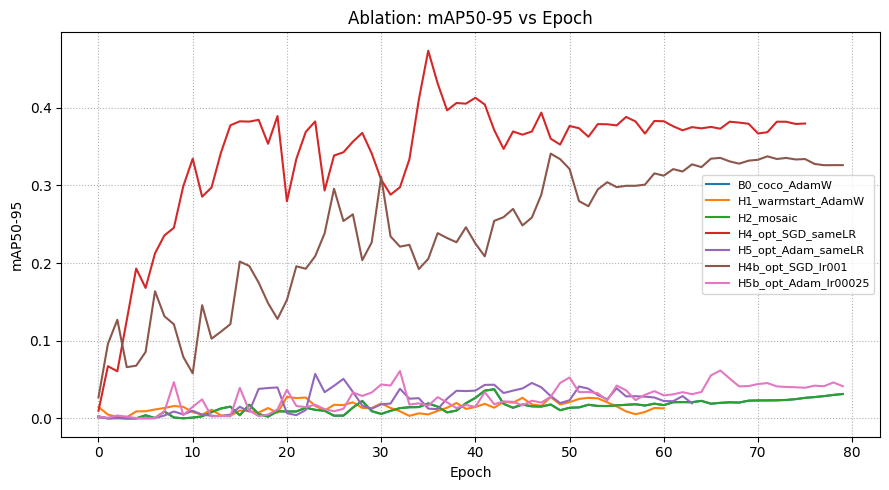

In [29]:
plt.figure(figsize=(9, 5))
for name, res in runs.items():
    if res is None: 
        continue
    run_dir = Path(res.save_dir)
    csv_path = run_dir / "results.csv"
    if not csv_path.exists():
        continue
    df = pd.read_csv(csv_path)
    m_col = [c for c in df.columns if "metrics/mAP50-95" in c][0]
    plt.plot(np.arange(len(df)), df[m_col].astype(float), label=name)

plt.xlabel("Epoch"); plt.ylabel("mAP50-95")
plt.title("Ablation: mAP50-95 vs Epoch")
plt.grid(True, linestyle=":")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(Path("runs/ablation_study/mAP_curves.png"), dpi=200)
plt.show()

#### This plot shows how mAP50-95 evolves over epochs for the same set of experiments.
#### The two curves at the top are the two SGD runs. You can see that they climb very quickly within the first 10–15 epochs, and the best one, stabilises around 0.4–0.47 mAP. This shows that SGD not only gives the best final score but also learns reliably and early.
#### The baseline and the Adam variants all stay very close to zero mAP throughout training. They do fluctuate a bit, but they never manage to climb out of that low-performance regime.
#### The warm-start and mosaic runs behave similarly their curves also hover near zero. The model simply isn’t learning good boxes under AdamW/Adam for this dataset.
#### For the ablation study, possible reasons why SGD outperforms Adam/AdamW because the YOLO training is tuned for SGD, our dataset is small with COCO pre-training so gentle updates help, and SGD’s implicit regularisation gives better generalisation on this detection task.


### Final Version 2 model

In [33]:
BEST_V2AB = dict(
    data=str(V2_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.004,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_final_sgd", exist_ok=True
)

model = YOLO("yolov8s.pt")
results = model.train(**BEST_V2AB)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [34]:
metrics = model.val(data=str(V2_YAML))
print(f"mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 122.031.9 MB/s, size: 59.5 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v2\valid\labels.cache... 120 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 120.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.1it/s 3.8s0.2ss
                   all        120        123      0.644      0.725      0.729      0.434
            benchpress         19         23      0.565      0.826      0.732      0.453
              deadlift         20         20      0.709          1      0.898      0.608
               leg_ext         20         20      0.773        0.9      0.905      0.585
           

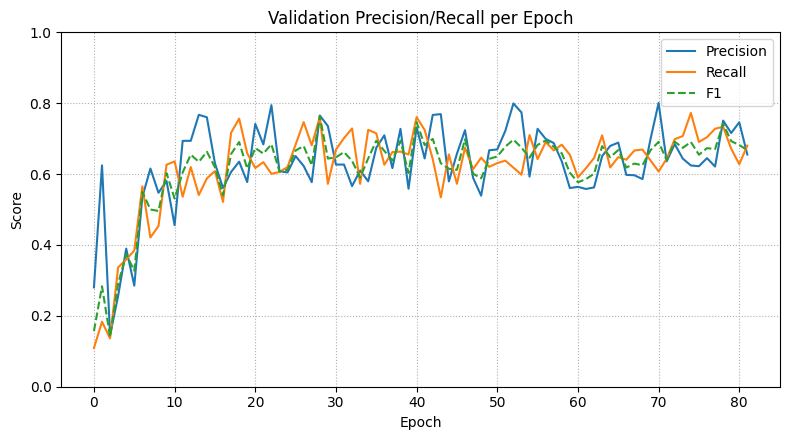

In [ ]:
run_dir = Path(results.save_dir)  # e.g. runs/detect/exercise_v1
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

#### This shows the performance of our Model V2 after ultilising what we have learned from the ablation study. 
#### Overall, V2 is reasonably strong, precision and recall are both in the 0.7 to 0.8 range, with an mAP@50 of about 0.78 and mAP@[50:95] of about 0.43. The best classes are deadlift and leg extension while pushup and shoulder press are the lowest. The plot shows validation precision, recall and F1 across epochs. We see a steep improvement in the first ~10 epochs, then the curves stabilise with only small fluctuations, so training is quite stable. Precision is slightly higher than recall, which means the model is a bit conservative. It prefers to miss some detections rather than produce too many false positives.

### Next, we continue our 'Active Learning' where we use the v2 model to predict the next 300 images to get the labels and bounding boxes.

In [36]:
# --- config you change per round ---
ROUND = "v3" 
ROOT = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset")

# use your latest trained weights for pseudo-labels (v2 best)
WEIGHTS = ROOT.parent / "runs" / "exercise_final_sgd" / "weights" / "best.pt"
if not WEIGHTS.exists():
    WEIGHTS = ROOT.parent / "runs" / "exercise_v1" / "weights" / "best.pt"
if not WEIGHTS.exists():
    WEIGHTS = Path("yolov8s.pt")

N_TRAIN_PER_CLASS = 40
N_VAL_PER_CLASS   = 10

SEED = 42
CONF, IOU, IMGSZ = 0.50, 0.40, 896
MAXDET = 6

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp",
            ".JPG",".JPEG",".PNG",".BMP",".TIF",".TIFF",".WEBP"}

# --- paths ---
TRAIN_EXIST = ROOT / "images" / "train"
VAL_EXIST   = ROOT / "images" / "val"
POOL_A      = ROOT / "pool_dataset"
POOL_B      = ROOT / "pool_dataset_cz"

OUT         = ROOT / ROUND
OUT_IMG_T   = OUT / "images" / "train"
OUT_IMG_V   = OUT / "images" / "val"
OUT_LAB_T   = OUT / "labels" / "train"
OUT_LAB_V   = OUT / "labels" / "val"
for d in [OUT_IMG_T, OUT_IMG_V, OUT_LAB_T, OUT_LAB_V]:
    d.mkdir(parents=True, exist_ok=True)

# --- helpers (same as your v2 script) ---
def list_imgs(d: Path):
    return [p for p in d.iterdir() if p.is_file() and p.suffix in IMG_EXTS]

def stems_in(d: Path):
    return {p.stem for p in d.rglob("*") if p.suffix in IMG_EXTS}

# avoid overlap with existing splits
ban_stems = set()
ban_stems |= stems_in(TRAIN_EXIST) if TRAIN_EXIST.exists() else set()
ban_stems |= stems_in(VAL_EXIST)   if VAL_EXIST.exists()   else set()

# also avoid reusing picks from previous rounds (e.g., v2) if not yet merged
PREV_ROUNDS = [ROOT / "v2"]   # add more if you have v1, v2, ...
for R in PREV_ROUNDS:
    for sub in ["images/train", "images/val"]:
        d = R / sub
        if d.exists():
            ban_stems |= stems_in(d)

rng = random.Random(SEED)

classes = sorted([x.name for x in POOL_A.iterdir() if x.is_dir()])
assert all((POOL_B / c).exists() for c in classes), "Class folders mismatch between pools."

print("Picking TRAIN from pool_dataset …")
picked_train = pick_and_copy(POOL_A, OUT_IMG_T, N_TRAIN_PER_CLASS, ban_stems)

if N_VAL_PER_CLASS > 0:
    print("\nPicking VAL from pool_dataset_cz …")
    picked_val = pick_and_copy(POOL_B, OUT_IMG_V, N_VAL_PER_CLASS, ban_stems)
else:
    picked_val = []

print(f"\nTotals: train={len(picked_train)}  val={len(picked_val)}")

model = YOLO(str(WEIGHTS))

lab_t_src = predict_into("train", OUT_IMG_T)
materialize_labels(OUT_IMG_T, lab_t_src, OUT_LAB_T)

if N_VAL_PER_CLASS > 0:
    lab_v_src = predict_into("val", OUT_IMG_V)
    materialize_labels(OUT_IMG_V, lab_v_src, OUT_LAB_V)


Picking TRAIN from pool_dataset …
pool_dataset/benchpress       -> 40/40
pool_dataset/deadlift         -> 40/40
pool_dataset/leg_extension    -> 40/40
pool_dataset/pushup           -> 40/40
pool_dataset/shoulder_press   -> 40/40
pool_dataset/squat            -> 40/40

Picking VAL from pool_dataset_cz …
pool_dataset_cz/benchpress       -> 10/10
pool_dataset_cz/deadlift         -> 10/10
pool_dataset_cz/leg_extension    -> 10/10
pool_dataset_cz/pushup           -> 10/10
pool_dataset_cz/shoulder_press   -> 10/10
pool_dataset_cz/squat            -> 10/10

Totals: train=240  val=60

image 1/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v3\images\train\bench press_1100001.jpg: 672x896 1 benchpress, 56.8ms
image 2/240 C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v3\images\train\bench press_2300031.jpg: 672x896 1 benchpress, 29.3ms
image 3/24

# Version 3

### Next for our version 3, we also train 2 models, baseline and a warm start from using the weights from the previous model. Both uses the same parameters as version 2. 

### Baseline

In [ ]:
RUN_NAME = "v3_baseline"

BASE_V3 = dict(
    data=str(V3_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.004,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_v3baseline", exist_ok=True
)

model = YOLO("yolov8s.pt")
results = model.train(**BASE_V3)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [4]:
# Evaluate on V3 val/test
best_pt = rf"runs/exercise_v3baseline/weights/best.pt"
m = YOLO(best_pt)
metrics = m.val(data=V3_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 455.1231.3 MB/s, size: 59.2 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.2it/s 3.8s0.2s
                   all        180        186       0.76      0.694      0.806      0.484
            benchpress         31         35      0.591      0.857      0.836      0.505
              deadlift         30         32      0.795      0.938      0.956      0.651
               leg_ext         30         30      0.799        0.8      0.879      0.579
                pus

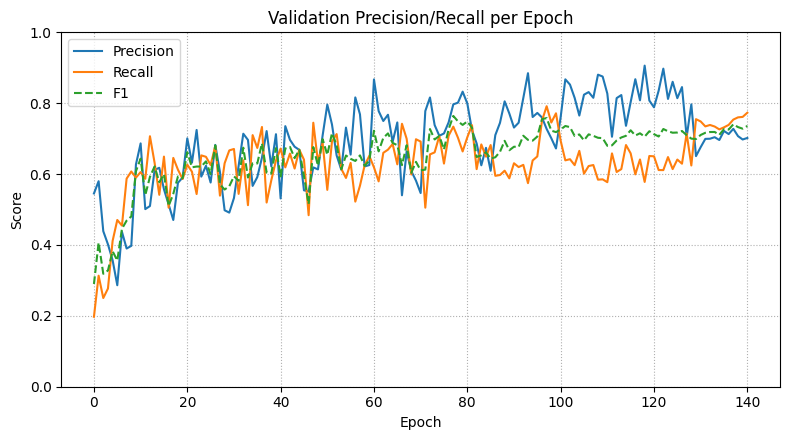

In [ ]:
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3baseline")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

### Warmstart

In [ ]:
RUN_NAME = "v3_best"
V3_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml")

BEST_V3 = dict(
    data=str(V3_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.002,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_v3best", exist_ok=True
)

model = YOLO(BEST_V2)
results = model.train(**BEST_V3)

New https://pypi.org/project/ultralytics/8.3.226 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [8]:
# Evaluate on V3 val/test
best_pt = rf"runs/exercise_v3best/weights/best.pt"
m = YOLO(best_pt)
metrics = m.val(data=V3_YAML)
print(f"[{RUN_NAME}] mAP50={metrics.box.map50:.3f}  mAP50-95={metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 334.1189.9 MB/s, size: 59.2 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 180.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.9it/s 4.2s0.2s
                   all        180        186       0.77      0.671      0.819      0.495
            benchpress         31         35      0.748      0.857      0.841      0.553
              deadlift         30         32      0.837          1      0.991      0.733
               leg_ext         30         30      0.874      0.967      0.968      0.635
         

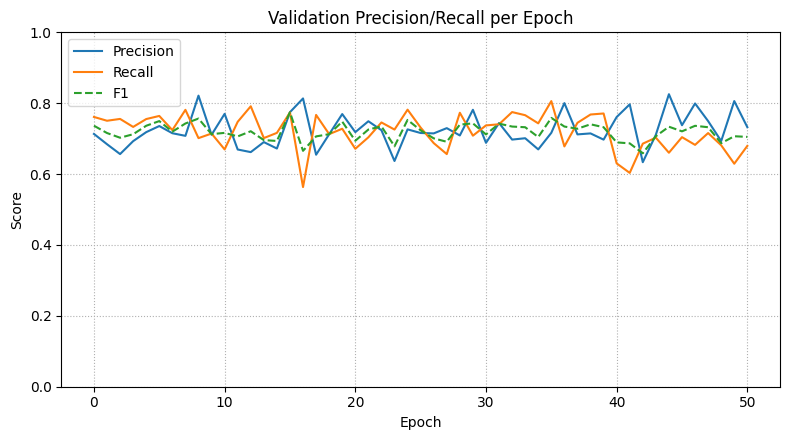

In [9]:
%matplotlib inline
run_dir = Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3best")
df = pd.read_csv(run_dir / "results.csv")

p_col = next(c for c in df.columns if "metrics/precision" in c)  # 'metrics/precision(B)'
r_col = next(c for c in df.columns if "metrics/recall" in c)     # 'metrics/recall(B)'

epochs = np.arange(len(df))
p = df[p_col].astype(float)
r = df[r_col].astype(float)
f1 = (2 * p * r / (p + r).replace(0, np.nan)).fillna(0.0)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(epochs, p, label="Precision")
plt.plot(epochs, r, label="Recall")
plt.plot(epochs, f1, linestyle="--", label="F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0, 1)
plt.title("Validation Precision/Recall per Epoch")
plt.grid(True, linestyle=":")
plt.legend(); plt.tight_layout()

# show first...
plt.show()

# ...then save to your run folder
fig.savefig(run_dir / "precision_recall_f1_per_epoch.png", dpi=200)

### Comparison of both models

In [5]:
BASE_PT = rf"runs/exercise_v3baseline/weights/best.pt"
BEST_PT = rf"runs/exercise_v3best/weights/best.pt"

def load_class_names(yaml_path):
    with open(yaml_path, "r", encoding="utf-8") as f:
        y = yaml.safe_load(f)
    if isinstance(y.get("names"), list):
        return y["names"]
    return [y["names"][i] for i in range(len(y["names"]))]

NAMES = load_class_names(V3_YAML)

def eval_model(weights_path, yaml_path):
    y = YOLO(weights_path)
    metrics = y.val(data=yaml_path, verbose=False, plots=False)
    # overall
    out = {
        "mAP50": float(metrics.box.map50),
        "mAP50-95": float(metrics.box.map),
    }
    # per-class (Ultralytics reliably exposes per-class mAP50-95 as metrics.box.maps)
    per_ap5095 = list(metrics.box.maps)
    # try to fetch per-class AP50 if available on your version; else None
    per_ap50 = getattr(metrics.box, "maps50", None)
    if per_ap50 is not None:
        per_ap50 = list(per_ap50)
    return out, per_ap50, per_ap5095

# ---- run evals
overall_base, ap50_base, ap5095_base = eval_model(BASE_PT, V3_YAML)
overall_best, ap50_best, ap5095_best = eval_model(BEST_PT, V3_YAML)

# 1) One-glance comparison table
df_overall = pd.DataFrame([
    {"Model":"V3 baseline (COCO init)", **overall_base},
    {"Model":"V3 best (warm-start from V2)", **overall_best},
])

# 2) Per-class table (uses AP50 if available; otherwise mAP50-95). Also compute deltas.
def per_class_df(names, base50, best50, base5095, best5095):
    rows = []
    for i, cls in enumerate(names):
        row = {"Class": cls}
        # AP50 columns (if available)
        if base50 is not None and best50 is not None:
            row["AP50_V3_base"] = round(float(base50[i]), 4)
            row["AP50_V3_best"] = round(float(best50[i]), 4)
            row["Δ AP50"]        = round(row["AP50_V3_best"] - row["AP50_V3_base"], 4)
        # AP50-95 columns (always available)
        row["mAP50-95_V3_base"] = round(float(base5095[i]), 4)
        row["mAP50-95_V3_best"] = round(float(best5095[i]), 4)
        row["Δ mAP50-95"]       = round(row["mAP50-95_V3_best"] - row["mAP50-95_V3_base"], 4)
        rows.append(row)
    # nice sort: largest improvement first by mAP50-95 delta
    return pd.DataFrame(rows).sort_values(by="Δ mAP50-95", ascending=False)

df_perclass = per_class_df(NAMES, ap50_base, ap50_best, ap5095_base, ap5095_best)

def hide_index(styler):
    if hasattr(styler, "hide"):
        return styler.hide(axis="index")
    if hasattr(styler, "hide_index"):
        return styler.hide_index()
    return styler.set_table_styles([
        {"selector": "th.row_heading", "props": [("display", "none")]},
        {"selector": "tbody tr th",    "props": [("display", "none")]}
    ])

def pretty(styler):
    return (hide_index(styler)
            .set_properties(**{"text-align": "center", "padding": "6px 12px"}))

# ---- OVERALL ----
display(pretty(
    df_overall.rename(columns={"mAP50":"mAP@50","mAP50-95":"mAP@[50:95]"})
              .round(3)
              .style
))

# ---- PER-CLASS ----
use_ap50 = "Δ AP50" in df_perclass.columns
cols_gain = (["Class","AP50_V3_base","AP50_V3_best","Δ AP50"] if use_ap50 else ["Class"]) \
            + ["mAP50-95_V3_base","mAP50-95_V3_best","Δ mAP50-95"]

# A) sort by gain
t_gain = df_perclass.sort_values("Δ mAP50-95", ascending=False)[cols_gain].round(3)
display(pretty(t_gain.style))

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 6.24.4 MB/s, size: 49.8 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 180.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.3it/s 3.6s0.2s
                   all        180        186       0.76      0.694      0.806      0.484
Speed: 1.4ms preprocess, 10.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast

Model,mAP@50,mAP@[50:95]
V3 baseline (COCO init),0.806000,0.484000
V3 best (warm-start from V2),0.819000,0.495000


Class,mAP50-95_V3_base,mAP50-95_V3_best,Δ mAP50-95
deadlift,0.651000,0.733000,0.082000
leg_ext,0.579000,0.635000,0.056000
benchpress,0.505000,0.553000,0.048000
shoulder_press,0.209000,0.202000,-0.008000
pushup,0.484000,0.443000,-0.040000
squat,0.473000,0.401000,-0.072000


#### Warm-starting gives a small but consistent boost in overall performance The per-class table below shows where that improvement comes from. Deadlift, leg extension and bench press all see nice gains in mAP. However, pushup, shoulder press and squat either stay the same or get slightly worse.

### Analysis of model

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 382.6152.6 MB/s, size: 52.0 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 180.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.6it/s 3.3s0.3s
                   all        180        186       0.77      0.671      0.819      0.495
            benchpress         31         35      0.748      0.857      0.841      0.553
              deadlift         30         32      0.837          1      0.991      0.733
               leg_ext         30         30      0.874      0.967      0.968      0.635
         

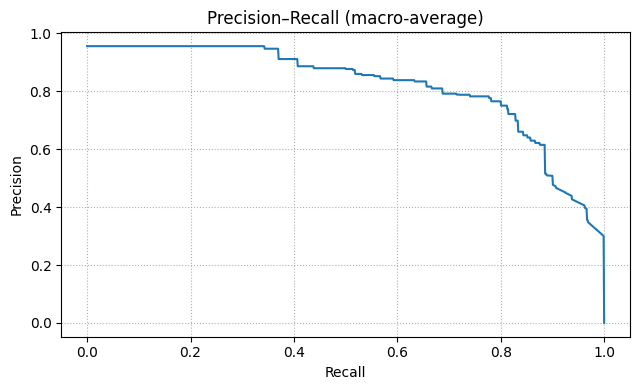

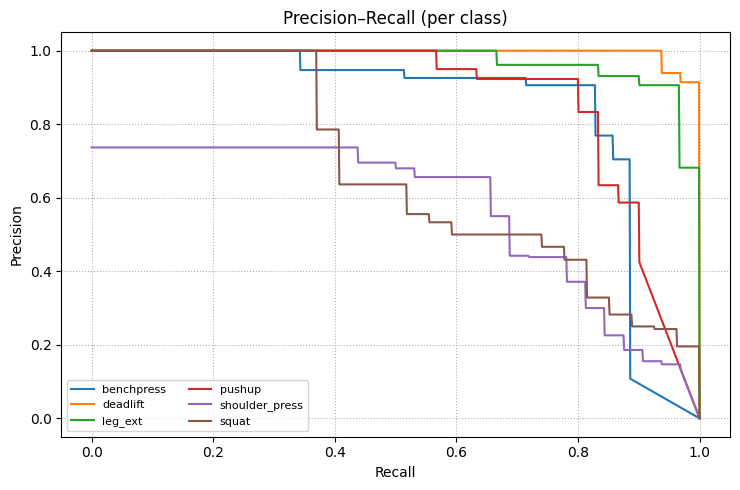

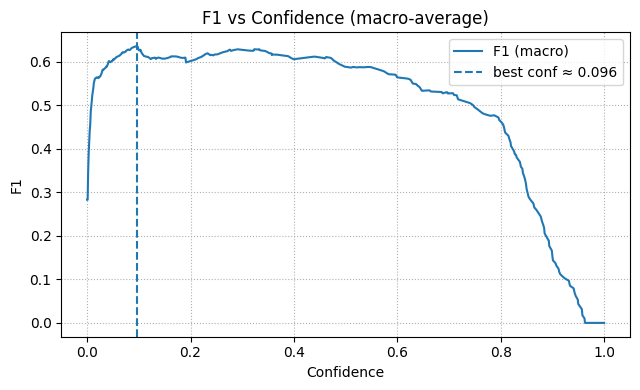

Recommended global conf (F1-max, macro): 0.096  (F1=0.636)


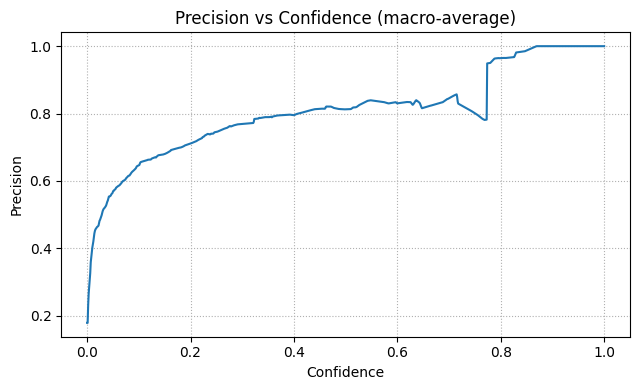

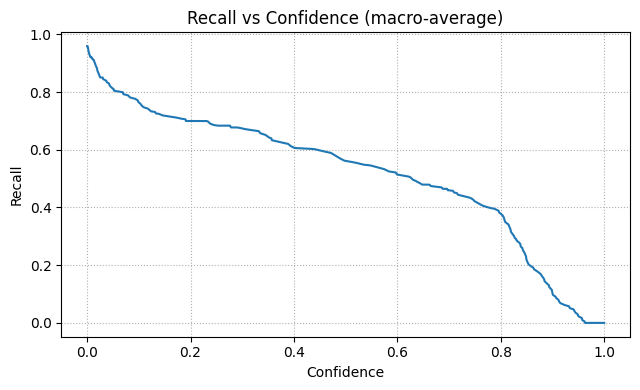

Saved plots in: C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\detect\val30


In [6]:
# --- run val and set dirs ---
v = YOLO(str(BEST_PT)).val(data=str(V3_YAML), imgsz=896, plots=True, workers=0)
run_dir = Path(v.save_dir)
run_dir.mkdir(parents=True, exist_ok=True)

# --- load class names for legends ---
with open(V3_YAML, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f).get("names", [])
if isinstance(names, dict):
    # if dict {id:name}, convert to list in id order
    names = [names[i] for i in range(len(names))]
num_classes = len(names) if names else None

def find_curve_index(v, substr):
    return next(i for i, k in enumerate(v.curves) if substr in k)

def extract_xy_matrix(v, name_substr):
    """Return x: (N,), y_mat: (C, N) where C=num_classes or 1 if already averaged."""
    i = find_curve_index(v, name_substr)
    item = v.curves_results[i]
    x = np.asarray(item[0], dtype=float)
    y = np.asarray(item[1])
    # If y is (N,), promote to (1, N) for uniform handling
    if y.ndim == 1:
        y_mat = y[None, :].astype(float)
    elif y.ndim == 2:
        y_mat = y.astype(float)
    else:
        # fallback: try first two entries
        y_mat = np.asarray(item[1], dtype=float)
        if y_mat.ndim == 1:
            y_mat = y_mat[None, :]
    return x, y_mat

def plot_xy(title, x, y, xlabel, ylabel, fname):
    fig = plt.figure(figsize=(6.5, 4))
    plt.plot(x, y)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    fig.savefig(run_dir / fname, dpi=200)
    plt.show(); plt.close(fig)

# 1) Precision–Recall (macro-average across classes)
xr, y_pr_mat = extract_xy_matrix(v, "Precision-Recall")
y_pr_mean = y_pr_mat.mean(axis=0)
plot_xy("Precision–Recall (macro-average)", xr, y_pr_mean, "Recall", "Precision", "pr_curve_mean.png")

# Optional: per-class PR curves
if y_pr_mat.shape[0] > 1:
    fig = plt.figure(figsize=(7.5, 5))
    for ci in range(y_pr_mat.shape[0]):
        label = names[ci] if names and ci < len(names) else f"class {ci}"
        plt.plot(xr, y_pr_mat[ci], label=label)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (per class)")
    plt.grid(True, linestyle=":"); plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    fig.savefig(run_dir / "pr_curve_per_class.png", dpi=200)
    plt.show(); plt.close(fig)

# 2) F1 vs Confidence (macro-average) + best threshold
xc, y_f1_mat = extract_xy_matrix(v, "F1-Confidence")
y_f1_mean = y_f1_mat.mean(axis=0)
best_i = int(np.argmax(y_f1_mean))
best_conf, best_f1 = float(xc[best_i]), float(y_f1_mean[best_i])

fig = plt.figure(figsize=(6.5, 4))
plt.plot(xc, y_f1_mean, label="F1 (macro)")
plt.axvline(best_conf, ls="--", label=f"best conf ≈ {best_conf:.3f}")
plt.xlabel("Confidence"); plt.ylabel("F1"); plt.title("F1 vs Confidence (macro-average)")
plt.grid(True, linestyle=":"); plt.legend(); plt.tight_layout()
fig.savefig(run_dir / "f1_vs_conf_mean.png", dpi=200)
plt.show(); plt.close(fig)
print(f"Recommended global conf (F1-max, macro): {best_conf:.3f}  (F1={best_f1:.3f})")

# 3) Precision vs Confidence (macro-average)
xc, y_pconf_mat = extract_xy_matrix(v, "Precision-Confidence")
plot_xy("Precision vs Confidence (macro-average)", xc, y_pconf_mat.mean(axis=0),
        "Confidence", "Precision", "precision_vs_conf_mean.png")

# 4) Recall vs Confidence (macro-average)
xc, y_rconf_mat = extract_xy_matrix(v, "Recall-Confidence")
plot_xy("Recall vs Confidence (macro-average)", xc, y_rconf_mat.mean(axis=0),
        "Confidence", "Recall", "recall_vs_conf_mean.png")

print("Saved plots in:", run_dir)


1) Precision–Recall (macro-average)

- The curve hugs the top left for recall ≤ ~0.5 → the model keeps high precision while picking up about half the positives.

- Past ~0.6 recall, precision drops steadily; near recall ≈ 1.0, precision falls.

- The detector is confident on many easy cases, but pushing recall higher costs precision.

2) Precision–Recall (per class)

- Curves near the top-right are the strong classes (e.g., deadlift, leg_ext).

- Curves that drop early are weaker/ambiguous.


3) F1 vs Confidence (macro-average)

- Peak at conf ≈ 0.096 (F1 ≈ 0.636).

- Lowering the threshold from typical 0.25–0.5 gives much more recall with only a modest precision hit.

- Deployment starting point: global conf≈0.10.

4) Precision vs Confidence / Recall vs Confidence

- Precision increase monotonically with confidence. Recall decreases monotonically.

- The kink around ~0.6–0.7 suggests a small calibration bump.

In [ ]:
with open(V3_YAML, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f)["names"]
if isinstance(names, dict):
    names = [names[i] for i in range(len(names))]

# Find the "F1-Confidence" curve, get X (conf) and Y matrix (classes x points)
idx = next(i for i,k in enumerate(v.curves) if "F1-Confidence" in k)
conf_grid = np.asarray(v.curves_results[idx][0], float)    
F1_mat    = np.asarray(v.curves_results[idx][1], float)  

best_idx  = F1_mat.argmax(axis=1)                             
best_conf = conf_grid[best_idx]                                
best_f1   = F1_mat[np.arange(F1_mat.shape[0]), best_idx]

for i, (c, f) in enumerate(zip(best_conf, best_f1)):
    print(f"{i:>2} {names[i]:<16} conf*={c:.3f}   F1={f:.3f}")

 0 benchpress       conf*=0.497   F1=0.866
 1 deadlift         conf*=0.765   F1=0.968
 2 leg_ext          conf*=0.358   F1=0.935
 3 pushup           conf*=0.015   F1=0.853
 4 shoulder_press   conf*=0.096   F1=0.656
 5 squat            conf*=0.332   F1=0.593


In [16]:
v = YOLO(BEST_PT).val(data=V3_YAML, imgsz=896, plots=True, workers=0)

Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.90.2 ms, read: 8.14.5 MB/s, size: 71.5 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v3\valid\labels.cache... 180 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.2it/s 5.3s0.4s
                   all        180        186      0.775      0.768       0.83      0.499
            benchpress         31         35      0.573      0.886      0.791      0.499
              deadlift         30         32      0.847          1      0.977       0.71
               leg_ext         30         30      0.925      0.822      0.967      0.653
                pushup 

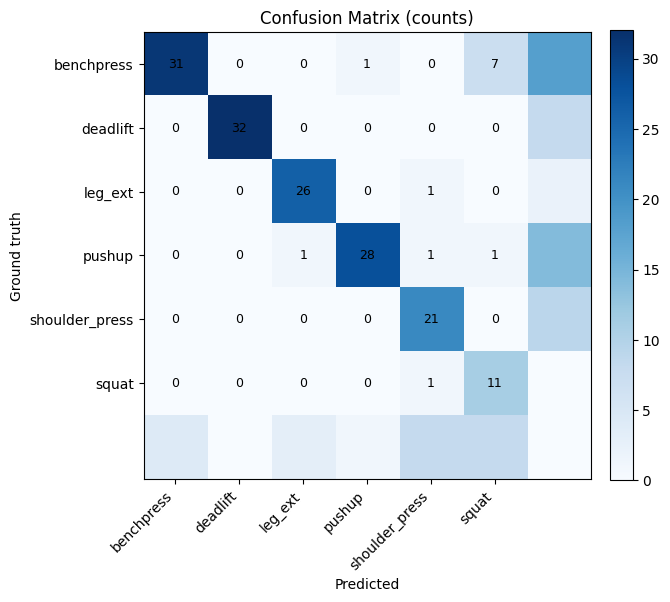

Saved: C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\detect\val36\confusion_counts.png


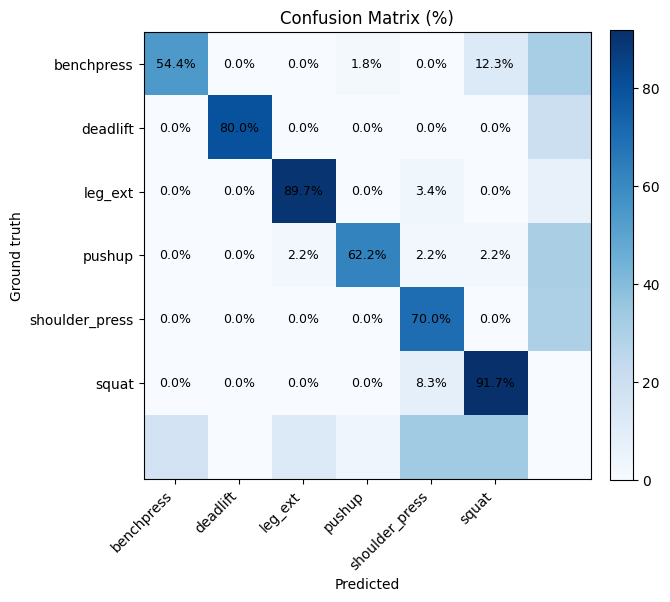

Saved: C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\detect\val36\confusion_percent.png


In [ ]:
save_dir = Path(v.save_dir)
cm = np.array(v.confusion_matrix.matrix, dtype=float)
assert cm.size > 0, "Confusion matrix is empty. Ensure val set has labels and the val() completed."

# Load class names from your data.yaml
with open(str(V3_YAML), "r", encoding="utf-8") as f:
    y = yaml.safe_load(f)
names = y["names"] if isinstance(y["names"], list) else [y["names"][i] for i in range(len(y["names"]))]

def plot_cm(mat, names, title, fname, fmt="%d"):
    C = len(names)
    fig, ax = plt.subplots(figsize=(0.8*C + 2, 0.8*C + 2))
    im = ax.imshow(mat, cmap="Blues")
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(C), labels=names, rotation=45, ha="right")
    ax.set_yticks(np.arange(C), labels=names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Ground truth")
    ax.set_title(title)
    # annotate cells
    for i in range(C):
        for j in range(C):
            val = mat[i, j]
            ax.text(j, i, (fmt % val) if fmt != "%.1f%%" else (fmt % val),
                    ha="center", va="center", color="black", fontsize=9)
    plt.tight_layout()
    out = save_dir / fname
    fig.savefig(out, dpi=200)
    plt.show()
    plt.close(fig)
    print("Saved:", out)

# 1) Counts heatmap
plot_cm(cm, names, "Confusion Matrix (counts)", "confusion_counts.png", fmt="%d")

# 2) Row-normalized (%) heatmap
row_sums = cm.sum(axis=1, keepdims=True) + 1e-9
cm_pct = (cm / row_sums) * 100.0
plot_cm(cm_pct, names, "Confusion Matrix (%)", "confusion_percent.png", fmt="%.1f%%")


#### This confusion matrix helps us see how V3 is making mistakes. The diagonal cells are correct predictions.
#### We see a fairly strong diagonal overall, which means the model is usually predicting the correct exercise. In particular, leg extension and squat are very reliable, with around 90% correct predictions, and deadlift is around 80%.
#### Two classes stand out as weaker. Bench press is only correctly classified about 54% of the time, and a large chunk of bench press samples are misclassified as squat. Pushup is also noisy: only about 62% of pushup reps are detected as pushup, with the rest spread across leg extension, shoulder press and squat. Shoulder press is around 70% correct and sometimes gets confused with squat as well.
#### The bottom row represents false positives — detections that don’t correspond to any ground truth — and we can see many of these are predicted as pushup or squat, which matches the higher confusion for those movements.


#### Feature map and occlusion

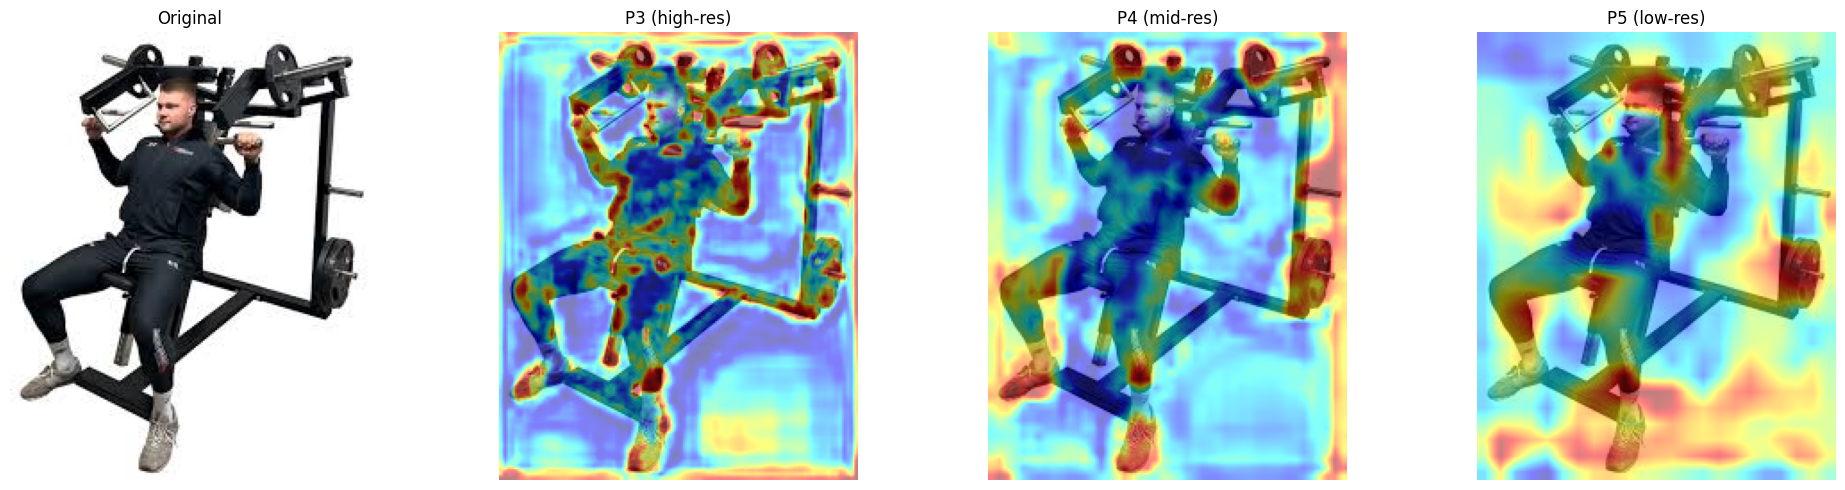

In [ ]:
IMGSZ = 896
PERC  = (2, 98)   # percentile scaling for contrast

# --- 2) helpers ---
def _find_detect(net):
    for m in net.modules():
        if m.__class__.__name__.lower() == "detect":
            return m
    raise RuntimeError("Detect head not found")

def _fmap_to_heat(feat, perc=PERC):
    # feat: [C,H,W] tensor (on CPU). Use L2 energy across channels for sharper maps.
    feat = feat.float().cpu()
    heat = torch.sqrt((feat**2).mean(dim=0) + 1e-9).numpy()
    lo, hi = np.percentile(heat, perc)
    heat = np.clip((heat - lo) / (hi - lo + 1e-6), 0, 1)
    return heat

def _overlay(bgr, heat, alpha=0.5):
    H, W = bgr.shape[:2]
    hm = cv2.applyColorMap((cv2.resize((heat*255).astype(np.uint8), (W, H))), cv2.COLORMAP_JET)
    out = (alpha*hm + (1-alpha)*bgr).astype(np.uint8)
    return cv2.cvtColor(out, cv2.COLOR_BGR2RGB)  # for plt.imshow()

def get_pyramid(yolo, bgr, imgsz=IMGSZ):
    """Returns list of tensors [P3, P4, P5], each as [C,H,W] on CPU."""
    net = yolo.model
    detect = _find_detect(net)
    buf = {}

    def hook(m, inp, out):
        x = inp[0] if isinstance(inp, (list, tuple)) else inp
        xs = x if isinstance(x, (list, tuple)) else [x]   # [P3, P4, P5]
        buf["pyr"] = [xi.detach()[0].cpu() for xi in xs]  # take batch idx 0

    h = detect.register_forward_hook(hook)
    yolo.predict([bgr], imgsz=imgsz, conf=0.01, iou=0.5, save=False, workers=0, verbose=False)
    h.remove()
    if "pyr" not in buf:
        raise RuntimeError("Could not capture Detect inputs.")
    return buf["pyr"]

# --- 3) run on one image and SHOW inline ---
WEIGHTS = r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3best\weights\best.pt"
INPUT   =  r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\test_images\test_ohp_5.jpg"

y = YOLO(WEIGHTS)
bgr = cv2.imread(INPUT); assert bgr is not None, "Image not found"

pyr = get_pyramid(y, bgr)  # list of [C,H,W] tensors
names = ["P3 (high-res)", "P4 (mid-res)", "P5 (low-res)"][:len(pyr)]

# show original + overlays
fig, axes = plt.subplots(1, len(pyr)+1, figsize=(5*(len(pyr)+1), 5))
axes[0].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); axes[0].set_title("Original"); axes[0].axis("off")

for ax, name, feat in zip(axes[1:], names, pyr):
    heat = _fmap_to_heat(feat)
    vis  = _overlay(bgr, heat, alpha=0.5)
    ax.imshow(vis); ax.set_title(name); ax.axis("off")

plt.tight_layout(); plt.show()


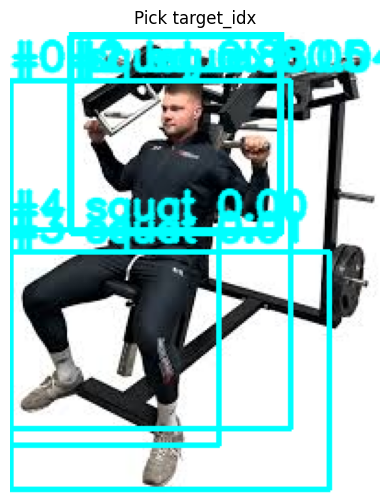

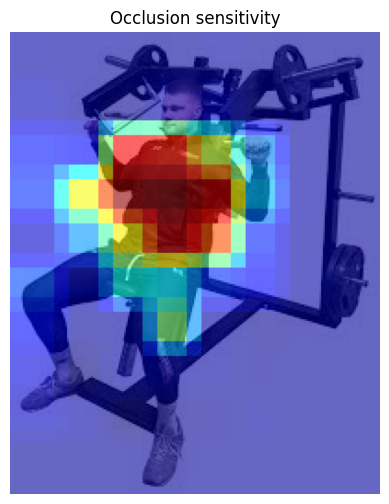

In [ ]:
from captum.attr import Occlusion
import torchvision.transforms as T
import torch, numpy as np

# --- helpers ---
def overlay_heat(rgb, heat, alpha=0.6):
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    hm = cv2.applyColorMap((heat*255).astype(np.uint8), cv2.COLORMAP_JET)[:, :, ::-1]
    return (alpha*hm + (1-alpha)*rgb).astype(np.uint8)

def choose_target(model, rgb, conf=0.001, iou=0.5, max_det=50):
    """Run YOLO once, show boxes with indices, return (boxes, clses, confs)."""
    r = model.predict(rgb, conf=conf, iou=iou, verbose=False, save=False, max_det=max_det)[0]
    if len(r.boxes)==0:
        raise ValueError("No detections.")
    boxes = r.boxes.xyxy.cpu().numpy()
    clses = r.boxes.cls.cpu().numpy().astype(int)
    confs = r.boxes.conf.cpu().numpy()
    vis = rgb.copy()
    for i,(b,k,c) in enumerate(zip(boxes, clses, confs)):
        x1,y1,x2,y2 = b.astype(int)
        cv2.rectangle(vis,(x1,y1),(x2,y2),(0,255,255),2)
        cv2.putText(vis, f"#{i} {model.names[k]} {c:.2f}", (x1, max(20,y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2, cv2.LINE_AA)
    plt.figure(figsize=(8,6)); plt.imshow(vis); plt.axis("off"); plt.title("Pick target_idx")
    plt.show()
    return boxes, clses, confs

# --- model & image ---
yolo = YOLO(WEIGHTS)
rgb  = cv2.cvtColor(cv2.imread(INPUT), cv2.COLOR_BGR2RGB)
boxes, clses, confs = choose_target(yolo, rgb)
target_idx = 0  # <-- set after viewing the plot
tbox, tcls = boxes[target_idx], clses[target_idx]

class YoloTarget(torch.nn.Module):
    def __init__(self, model, tbox, tcls, iou_match=0.3):
        super().__init__()
        self.model, self.tbox, self.tcls = model, tbox, tcls
        self.iou_match = iou_match

    @torch.no_grad()
    def forward(self, x):  # BCHW in [0,1]
        out = []
        for i in range(x.shape[0]):
            img = (x[i].permute(1,2,0).cpu().numpy()*255).astype('uint8')
            r = self.model.predict(img, conf=0.001, iou=0.5, verbose=False, save=False)[0]
            if len(r.boxes)==0: out.append(0.0); continue
            bxs = r.boxes.xyxy.cpu().numpy()
            scs = r.boxes.conf.cpu().numpy()
            cls = r.boxes.cls.cpu().numpy().astype(int)

            m = (cls==self.tcls); bxs, scs = bxs[m], scs[m]
            if len(scs)==0: out.append(0.0); continue

            x1 = np.maximum(bxs[:,0], self.tbox[0]); y1 = np.maximum(bxs[:,1], self.tbox[1])
            x2 = np.minimum(bxs[:,2], self.tbox[2]); y2 = np.minimum(bxs[:,3], self.tbox[3])
            inter = np.maximum(0,x2-x1)*np.maximum(0,y2-y1)
            a1 = (self.tbox[2]-self.tbox[0])*(self.tbox[3]-self.tbox[1])
            a2 = (bxs[:,2]-bxs[:,0])*(bxs[:,3]-bxs[:,1])
            iou = inter/(a1+a2-inter+1e-6)

            j = iou.argmax()
            out.append(float(scs[j]) if iou[j] >= self.iou_match else 0.0)
        return torch.tensor(out, dtype=torch.float32).unsqueeze(1)

x = T.ToTensor()(rgb).unsqueeze(0)               # 1x3xHxW
baseline_rgb = np.mean(rgb.reshape(-1,3), axis=0)  # per-channel mean
baseline = torch.tensor(baseline_rgb/255.0, dtype=torch.float32).view(1,3,1,1)

wrapped = YoloTarget(yolo, tbox, tcls, iou_match=0.35)
occl = Occlusion(wrapped)
attr = occl.attribute(
    x, strides=(1,24,24), sliding_window_shapes=(3,32,32), baselines=baseline,
    perturbations_per_eval=16
).squeeze(0).mean(0).cpu().numpy()

plt.figure(figsize=(8,6))
plt.imshow(overlay_heat(rgb, attr))
plt.axis("off")
plt.title("Occlusion sensitivity")
plt.show()

#### On P3, the high-resolution map lights up the hands on the handles, shoulder joints and upper torso. At P5, we see a broad blob covering the seated body and main part of the machine, capturing the overall exercise configuration.
#### The occlusion sensitivity on the right shows that blocking the chest, shoulders and handles causes the largest drop in confidence, confirming that the model keys in on the actual pressing motion rather than irrelevant parts of the image.
#### We have more analysis done in our presentation slides, with the link in the poster

#### Using version 3 model, we start on our version 4, focusing more on push up and shoulder press.

In [ ]:
BASE = Path(
    r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset"
)

POOL_FRONT = BASE / "pool_dataset"
POOL_CZ    = BASE / "pool_dataset_cz"
V4_ROOT    = BASE / "v4"

OUT_IMG_T = V4_ROOT / "images" / "train"
OUT_IMG_V = V4_ROOT / "images" / "val"
OUT_LAB_T = V4_ROOT / "labels" / "train"
OUT_LAB_V = V4_ROOT / "labels" / "val"

for d in [OUT_IMG_T, OUT_IMG_V, OUT_LAB_T, OUT_LAB_V]:
    d.mkdir(parents=True, exist_ok=True)

# previous splits (anything here is treated as "already used")
PREVIOUS_SPLITS = [
    BASE / "images",
    BASE / "v2",
    BASE / "v3",
]

BEST_V3 = BASE.parent / "runs" / "exercise_v3best" / "weights" / "best.pt"
if not BEST_V3.exists():
    raise FileNotFoundError(f"Best V3 weights not found at: {BEST_V3}")

# ======================================
# 1. CLASSES
# ======================================

TARGET_CLASS_MAP = {
    "push up":        ("pushup",        "pushup"),
    "shoulder press": ("shoulder_press", "shoulder_press"),
}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def list_imgs(root: Path) -> List[Path]:
    if not root.exists():
        return []
    return [p for p in root.rglob("*") if p.suffix.lower() in IMG_EXTS]

def collect_used_stems(root: Path) -> Set[str]:
    if not root.exists():
        return set()
    return {p.stem for p in list_imgs(root)}

# build "already used" stem set
used_stems_pre = set()
for ds in PREVIOUS_SPLITS:
    stems = collect_used_stems(ds)
    if stems:
        print(f"[INFO] {ds.name}: {len(stems)} used stems")
    used_stems_pre |= stems
print(f"[INFO] Total used stems from old splits: {len(used_stems_pre)}")

# also avoid duplicates inside v4
v4_stems: Set[str] = set()

# ======================================
# 2. PICK IMAGES (NEW-ONLY)
# ======================================

rng = random.Random(42)

N_TRAIN_PER_CLASS = 80
N_VAL_PER_CLASS   = 20

def pick_split(split: str, per_class: int) -> int:
    """
    split = 'train' or 'val'
    - train from POOL_FRONT
    - val   from POOL_CZ
    ONLY images whose stem is:
      - NOT in used_stems_pre
      - NOT already in v4_stems
    """
    global v4_stems
    total = 0
    for cname, (front_folder, cz_folder) in TARGET_CLASS_MAP.items():
        if split == "train":
            src = POOL_FRONT / front_folder
            dest_dir = OUT_IMG_T
        else:
            src = POOL_CZ / cz_folder
            dest_dir = OUT_IMG_V

        if not src.exists():
            print(f"[WARN] {split}: source folder does not exist: {src}")
            continue

        all_imgs = list_imgs(src)
        new_imgs = [p for p in all_imgs
                    if (p.stem not in used_stems_pre and p.stem not in v4_stems)]

        rng.shuffle(new_imgs)

        if not new_imgs:
            print(f"[WARN] {split}: NO UNUSED images for '{cname}' in {src}")
            continue

        n = min(per_class, len(new_imgs))
        chosen = new_imgs[:n]
        for p in chosen:
            shutil.copy2(p, dest_dir / p.name)
            v4_stems.add(p.stem)

        total += n
        print(
            f"[INFO] {split:<5} {cname:<16} -> picked {n:3d}/{per_class:3d} "
            f"(unused_candidates={len(new_imgs):4d})"
        )
    return total

train_count = pick_split("train", N_TRAIN_PER_CLASS)
val_count   = pick_split("val",   N_VAL_PER_CLASS)

print(f"\n[SUMMARY] v4 picks -> train={train_count}, val={val_count}")
print(f"[SUMMARY] distinct stems in v4: {len(v4_stems)}")

if train_count == 0:
    raise RuntimeError("No NEW train images were picked for v4 – check the debug counts above.")

# ======================================
# 3. PSEUDO-LABEL WITH BEST V3
# ======================================

from ultralytics import YOLO

model = YOLO(str(BEST_V3))
IMGSZ, CONF, IOU = 896, 0.20, 0.50

def predict_into(name: str, src_dir: Path):
    if not list_imgs(src_dir):
        print(f"[WARN] No images in {src_dir}, skipping prediction for {name}.")
        return None
    run_name = f"_pred_{name}"
    print(f"\n[INFO] Predicting {name} on {src_dir}")
    model.predict(
        source=str(src_dir),
        imgsz=IMGSZ,
        conf=CONF,
        iou=IOU,
        agnostic_nms=True,
        max_det=6,
        augment=False,
        save=False,
        save_txt=True,
        save_conf=True,
        project=str(V4_ROOT),
        name=run_name,
        exist_ok=True,
        verbose=False,
    )
    return V4_ROOT / run_name / "labels"

lab_t_dir = predict_into("train", OUT_IMG_T)
lab_v_dir = predict_into("val",   OUT_IMG_V)

# ======================================
# 4. MATERIALISE LABELS
# ======================================

def materialize_labels(img_dir: Path, pred_label_dir: Path, out_label_dir: Path):
    if pred_label_dir is None or not pred_label_dir.exists():
        print(f"[WARN] No pred labels for {img_dir}, skipping label copy.")
        return

    out_label_dir.mkdir(parents=True, exist_ok=True)
    img_stems = {p.stem for p in list_imgs(img_dir)}
    copied = 0
    for txt in pred_label_dir.glob("*.txt"):
        if txt.stem in img_stems:
            shutil.copy2(txt, out_label_dir / txt.name)
            copied += 1
    print(f"[INFO] Copied {copied} label files into {out_label_dir}")

materialize_labels(OUT_IMG_T, lab_t_dir, OUT_LAB_T)
materialize_labels(OUT_IMG_V, lab_v_dir, OUT_LAB_V)

print(
    "\n[DONE] v4 complete.\n"
    f"Images: train={len(list_imgs(OUT_IMG_T))}, val={len(list_imgs(OUT_IMG_V))}\n"
    f"Label files: train={len(list(OUT_LAB_T.glob('*.txt')))}, "
    f"val={len(list(OUT_LAB_V.glob('*.txt')))}"
)


[INFO] images: 300 used stems
[INFO] v2: 300 used stems
[INFO] v3: 300 used stems
[INFO] Total used stems from old splits: 900
[INFO] train push up          -> picked  80/ 80 (unused_candidates= 481)
[INFO] train shoulder press   -> picked  80/ 80 (unused_candidates= 392)
[INFO] val   push up          -> picked  20/ 20 (unused_candidates= 271)
[INFO] val   shoulder press   -> picked  20/ 20 (unused_candidates= 242)

[SUMMARY] v4 picks -> train=160, val=40
[SUMMARY] distinct stems in v4: 200

[INFO] Predicting train on C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v4\images\train
Results saved to C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v4\_pred_train
147 labels saved to C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Split_Dataset\v4\_pred_train\labels

[INFO] Predicting val 

# Version 4

In [7]:
RUN_NAME = "v4"
V4_YAML =  Path(r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v4\data.yaml")
BEST_V3 = r"C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\runs\exercise_v3best\weights\best.pt"

BEST_V4 = dict(
    data=str(V4_YAML),
    imgsz=896, rect=True,
    epochs=150, patience=40,
    batch=8, device=0, workers=2, cache="ram",
    optimizer="SGD", momentum=0.937,
    cos_lr=True, lr0=0.002,
    seed=42,
    # same mild augs
    fliplr=0.5, flipud=0.0, degrees=5.0, shear=2.0,
    translate=0.03, scale=0.5, mosaic=0.10, mixup=0.0,
    copy_paste=0.0, close_mosaic=15,
    project="runs", name="exercise_v4", exist_ok=True
)

model = YOLO(BEST_V3)
results = model.train(**BEST_V4)

New https://pypi.org/project/ultralytics/8.3.232 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v4\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, m

In [15]:
BEST_PT = rf"runs/exercise_v4/weights/best.pt"

def load_class_names(yaml_path):
    import yaml
    from pathlib import Path

    yaml_path = Path(yaml_path)
    with open(yaml_path, "r", encoding="utf-8") as f:
        y = yaml.safe_load(f)
    if isinstance(y.get("names"), list):
        return y["names"]
    return [y["names"][i] for i in range(len(y["names"]))]

NAMES = load_class_names(V4_YAML)

from ultralytics import YOLO

def eval_model(weights_path, yaml_path):
    y = YOLO(weights_path)
    metrics = y.val(data=str(yaml_path), verbose=False, plots=False)

    out = {
        "mAP50": float(metrics.box.map50),
        "mAP50-95": float(metrics.box.map),
    }

    # per-class mAP50-95 is always available
    per_ap5095 = list(metrics.box.maps)

    # per-class AP50 is available only on some versions
    per_ap50 = getattr(metrics.box, "maps50", None)
    if per_ap50 is not None:
        per_ap50 = list(per_ap50)

    return out, per_ap50, per_ap5095


# ---- run eval for V4 best ----
overall_v4, ap50_v4, ap5095_v4 = eval_model(BEST_PT, V4_YAML)

# 1) Overall table
df_overall = pd.DataFrame([
    {"Model": "V4 best", **overall_v4},
])


# 2) Per-class table for V4 only
def per_class_df(names, ap50, ap5095):
    rows = []
    for i, cls in enumerate(names):
        row = {"Class": cls}

        # AP50 column if available
        if ap50 is not None:
            row["AP50_V4"] = round(float(ap50[i]), 4)

        # AP50-95 column (always)
        row["mAP50-95_V4"] = round(float(ap5095[i]), 4)

        rows.append(row)

    # sort by mAP50-95 descending so best classes are at top
    return pd.DataFrame(rows).sort_values(by="mAP50-95_V4", ascending=False)

df_perclass = per_class_df(NAMES, ap50_v4, ap5095_v4)


# ---- styling helpers ----
def hide_index(styler):
    if hasattr(styler, "hide"):
        return styler.hide(axis="index")
    if hasattr(styler, "hide_index"):
        return styler.hide_index()
    return styler.set_table_styles([
        {"selector": "th.row_heading", "props": [("display", "none")]},
        {"selector": "tbody tr th",    "props": [("display", "none")]}
    ])

def pretty(styler):
    return (
        hide_index(styler)
        .set_properties(**{"text-align": "center", "padding": "6px 12px"})
    )


# ---- DISPLAY: OVERALL ----
display(pretty(
    df_overall.rename(columns={"mAP50": "mAP@50", "mAP50-95": "mAP@[50:95]"})
              .round(3)
              .style
))

# ---- DISPLAY: PER-CLASS ----
cols = ["Class"]
if ap50_v4 is not None:
    cols.append("AP50_V4")
cols.append("mAP50-95_V4")

t_v4 = df_perclass[cols].round(3)
display(pretty(t_v4.style))


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001B410188040>
Traceback (most recent call last):
  File "C:\Users\zihin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "C:\Users\zihin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Ultralytics 8.3.221  Python-3.11.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 441.4218.6 MB/s, size: 44.3 KB)
val: Scanning C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Annotated_v4\valid\labels.cache... 220 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 220/220  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 3.7it/s 3.8s0.2s
                   all        220        226      0.806       0.76       0.85      0.525
Speed: 1.1ms preprocess, 9.3ms inference, 0.0ms loss, 0.6ms postprocess per image


Model,mAP@50,mAP@[50:95]
V4 best,0.850000,0.525000


Class,mAP50-95_V4
deadlift,0.710000
leg_ext,0.653000
squat,0.504000
benchpress,0.496000
pushup,0.462000
shoulder_press,0.323000


#### This is our final model, V4.
#### Compared to V3_best, V4 achieves the highest overall accuracy: mAP@50 increases from about 0.82 to 0.85, and mAP@[50:95] from 0.50 to 0.53.
#### More importantly, the classes we specifically targeted – pushup and shoulder_press – both improved. Pushup goes from 0.443 to 0.462, and shoulder_press jumps from 0.202 to 0.323, which was previously our worst class. We do see a small trade-off: benchpress and deadlift drop slightly, but squat and leg extension also improve.
#### Overall, V4 shows that focused data collection and rebalancing can lift weak classes and improve the global mAP, rather than just blindly adding more data.


# Conclusion

#### In conclusion, by re-splitting the dataset, adding the AB set, and finally focusing on pushup and shoulder_press in V4, we improved overall mAP@[50:95] from about 0.43 up to 0.53, while significantly boosting the previously weakest classes.
#### Using feature-map visualisations and occlusion sensitivity, we showed that the model is generally attending to the right evidence – arms, shoulders, hips and the barbell – and we also uncovered typical failure modes, like some pushups being misclassified as deadlifts when the hip hinge dominates the image.
#### The main bottleneck now is still data: our dataset is relatively small, class-imbalanced, and based on single frames. The model still struggles with very similar poses or unusual camera angles.
#### Going forward, we’d like to collect a larger and more diverse dataset. More users, different gyms and angles that would improve our model significantly